# Introduction

In Lesson 6, *Kalman Filters*, we learned that a Kalman filter (KF) is a way to estimate the value of a signal in the presence of noise. We discussed how the it works conceptually and then described how the filter operates for two one-dimensional examples (static and dynamic). We concluded with a presentation of the equations that describe the general Kalman filter.

We will continue our discussion by implementing the recursive algorithm of the Kalman filter for the static and dynamic one-dimensional systems.  These two examples will lay the foundation to understand our third example with state vectors in higher dimension. Spend time to master the basic examples before proceeding to the more advanced one.

# Learning Outcomes

You should walk away from this Python tutorial with:
1. An understanding of the Kalman filter as a recursive algorithm
2. Knowledge of the importance of tuning the parameters of the Kalman filter
3. Some practical experience in using the Kalman filter

# Imports

In [2]:
%matplotlib inline

import sys
import statsmodels as ss
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
#import cv2

# Python & Library Versions

In [3]:
versions = ( ("matplotlib", matplotlib.__version__),
            ("numpy", np.__version__),
            ("pandas", pd.__version__),
            ("statsmodels", ss.__version__),
            ("opencv", cv2.__version__))

print(sys.version, "\n")
print("library" + " " * 4 + "version")
print("-" * 18)

for tup1, tup2 in versions:
    print("{:11} {}".format(tup1, tup2))

NameError: name 'cv2' is not defined

---

# Section 1: Overview of the Kalman Filter

In this lesson, we will use the Kalman filter to estimate the value of a signal from noisy data. Initially, we will construct the algorithm by hand so we understand all the steps involved. Also, we will generate datasets from scratch so we know what our true result should be and therefore gain insight into how well the Kalman Filter works. 

### The algorithm 

As we discussed in the lecture, this is workflow:

    - Make an initial estimate of your state vector and covariance matrix
    - Predict the state and covariance for the next time step
    - Computer the Kalman gain
    - Make a measurement
    - Update estimates of state and covariance 
    - Repeat

For our one-dimensional examples, there are a couple of simplifications: the state vector is a single number (a scalar) and the covariance matrix reduces to the variance (also a scalar). Therefore, only normal multiplication (as opposed to matrix multiplication) is involved.

# Section 2: Static one-dimensional example

Let's start by considering the first example we discussed in the lecture: determining the position of a stationary car. We'll assume that all we are interested in is a one-dimensional value, such as the distance along a road from a landmark. We are going to try to predict the true position based on some noisy measurements of the distance. Since we going to generate the noisy measurements by hand and we will know the true position, we can see how well our algorithm does. 

In the lecture, when we discussed this example, we focused on the measurement noise. Here we will include the model noise too. That is our model for the position will be **$x$ = constant + noise**. In other words, we have two noise parameters: one for the model and one for the measurement. This will make it easier to connect our static example to the dynamic one, where both types of noise are present. 


The values of two noise parameters——the variances of the model and the measurement noise——are inputs for the algorithm.  We usually don't know what they are, so we have to make reasonable estimates. In this example, we do know the actual variance for the measurements (since we are generating the measurements ourselves, we choose this parameter), so we can see the effect of making a good estimate (or a bad one) for this parameter. Also, we are going to choose the actual position of our car, so we can see how quickly the Kalman filter converges to the true algorithm.


Finally, we need to guess initial values for the initial position of the car and the variance in this initial estimate. And of course, we must specific the number of time points (measurements). Again, these are parameters that you are encouraged to modify to see how they affect convergence.



Let's take a look at how this works in practice. The implementation is adapted from a combination of sources:

https://stackoverflow.com/questions/13901997/kalman-2d-filter-in-python?rq=1,

http://scipy-cookbook.readthedocs.io/items/KalmanFiltering.html

And the article *Introduction to the Kalman Filter* (http://www.cs.unc.edu/~welch/media/pdf/kalman_intro.pdf).

In [4]:
# initial parameters
n_measurements_in_series = 1000
actual_position = 124.5 
estimated_model_variance = 1e-4 
estimated_measurement_variance = 2e-2 

# Note: if we assume that a measurement is taken every second, time starts at 0 and ends at (n_measurement_in_series-1) seconds 
# Also, if we measure all distances in meters, the variances will be in meter**2

# generate measurements 
np.random.seed(42) # specify seed of random number generator for repeatability
actual_stdev = 0.1 # standard deviation of actual measurements 
position_measurements = np.random.normal(actual_position,actual_stdev,size=n_measurements_in_series)

# initial guesses 
estimated_position = 124 # Use integer in this example——imagine initial guess was determined with a meter stick
error = 0.04 # this is a variance
KF_estimate=[] # To store the position estimate at each time point 
KF_error=[] # To store estimated error at each time point


It is always good practice to have a look at the data before carrying out any analysis. Since we are going to have similar plots, it makes sense to define a function.

In [5]:
def plot_1d_measurements(data, opacity):
    # opacity is a float between 0.0 and 1.0
    plt.figure(dpi=150)
    plt.plot(data,'k+',label='measurements',alpha=opacity)
    plt.title('Position vs Time', fontweight='bold')
    plt.xlabel('Time (s)')
    plt.ylabel('Position (m)')
    plt.show()

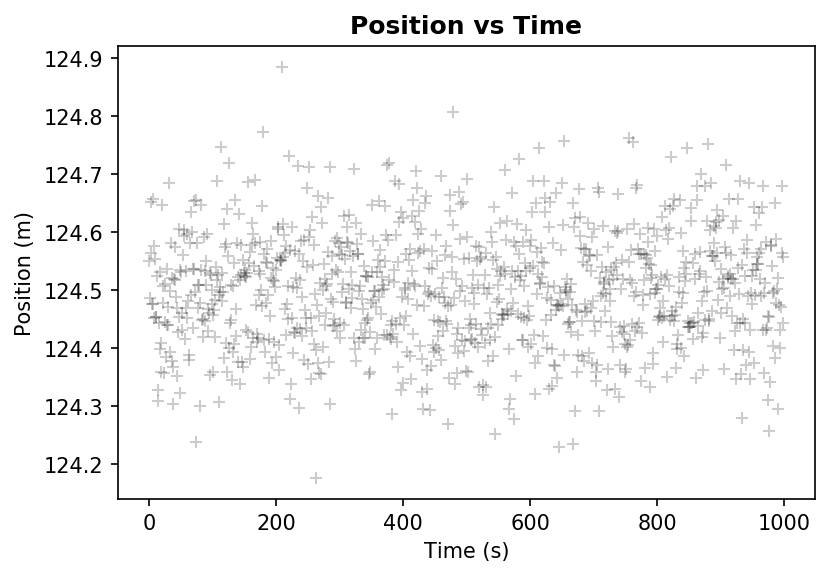

In [6]:
plot_1d_measurements(position_measurements, 0.2)

Create a function that computes the estimated position and associated error using the Kalman filter.

In [7]:
def kalman_1d(est_position, est_error, measurement, est_meas_variance, est_model_variance):
    
    '''
    Parameters:
    estimated_position
    error
    measuement
    estimated_measurement_variance
    estimated_model_variance

    Return: the new values for estimated_position and error after applying the Kalman filter 
    '''
    
    # predict next position and error
    #
    # Formally, we should include a prediction for the estimated_position
    # Since the model is x = constant + noise, this prediction would be 
    # est_position = est_position
    # As this is redundant, we don't write this line of code.
    #
    est_error = est_error+est_model_variance
    
    # calculate Kalman gain (note: est_error here is before measurement)
    K = est_error/(est_error+est_meas_variance)
    
    # update including new measurement
    est_position = est_position+K*(measurement-est_position)
    est_error = (1-K)*est_error

    return est_position, est_error

And apply the filter to the 1D static measurements

In [8]:
for meast in position_measurements:
    estimated_position, error = kalman_1d(estimated_position, error, meast, estimated_measurement_variance, estimated_model_variance)
    KF_estimate.append(estimated_position)
    KF_error.append(error)

Now, plot a comparison of the measurements, the estimate and the true value. And also plot the estimate_error (before the measurement) as a function of time step. Again, create functions for convenience.

In [9]:
def plot_1d_comparison(measurements_made, estimate, true_value):
    plt.figure(dpi=150)
    plt.plot(measurements_made,'k+',label='measurements',alpha=0.3)
    plt.plot(estimate,'-',label='KF estimate')
    if not isinstance(true_value, (list, tuple, np.ndarray)):
        # plot line for a constant value
        plt.axhline(true_value,color='r',label='true value', alpha=0.5) 
    else:
        # for a list, tuple or array, plot the points
        plt.plot(true_value,color='r',label='true value', alpha=0.5)
    plt.legend(loc = 'lower right')
    plt.title('Estimated position vs. time step', fontweight='bold')
    plt.xlabel('Time (s)')
    plt.ylabel('Position (m)')
    plt.show()
    
def plot_1d_error(estimated_error, lower_limit, upper_limit):
    # lower_limit and upper_limit are the lower and upper limits of the vertical axis 
    plt.figure(dpi=150)
    plt.plot(estimated_error, label='KF estimate for error')
    plt.legend(loc = 'upper right')
    plt.title('Estimated error vs. time step', fontweight='bold')
    plt.xlabel('Time (s)')
    plt.ylabel('Variance ($m^2$)')
    plt.setp(plt.gca(),'ylim',[lower_limit, upper_limit])
    plt.show()



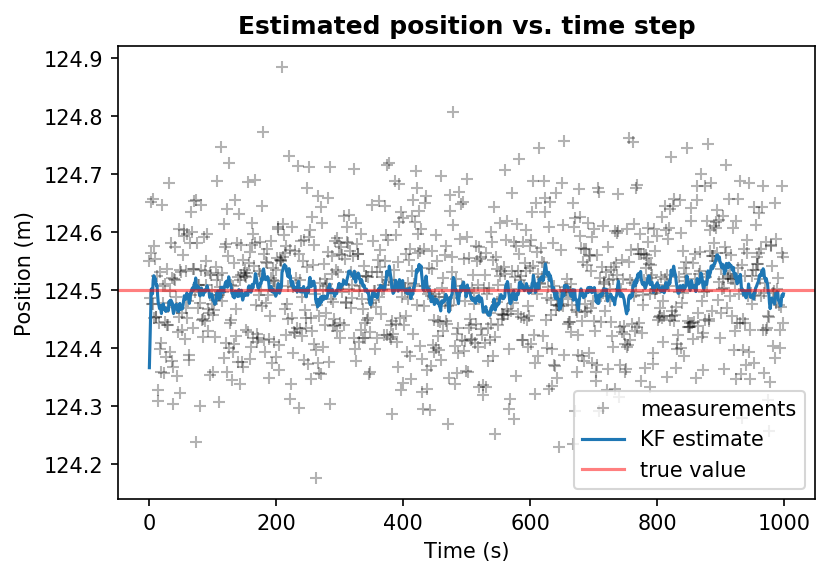

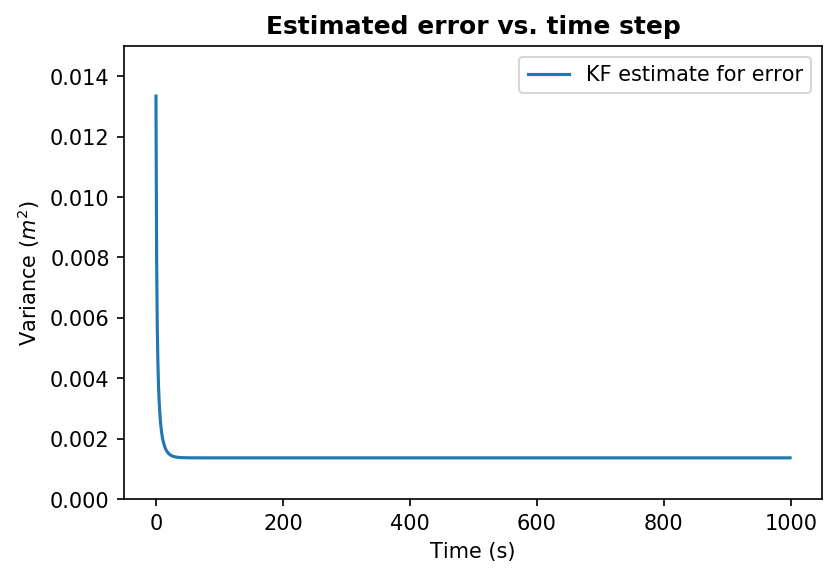

In [10]:
plot_1d_comparison(position_measurements, KF_estimate, actual_position)
plot_1d_error(KF_error, 0, 0.015)

We see that for the parameters we've chosen, the filter converges to the true value quickly and the noise is filtered out. Note that the KF estimates shown are those obtained after each measurement.

**Question:** How is the limiting value of the variance (the value at large times) related to the fluctuations seen in the estimated position? 

**Answer:** The fluctuations around the true value are approximately the size of the standard deviation of the error, which is the square root of the limiting variance.

# Section 2: Dynamic one-dimensional example

Now we move on to the second example we discussed in the lecture: a car moving at approximately constant velocity. In this case the model is

$dx/dt = u + w$, 

where $u$ is the constant velocity and $w$ represents the noise. In this case we will model $w$ with a Gaussian distribution that has zero mean and finite variance. As we will be generating the measurements by hand, we will select a value for this variance. We will also have to assign a value to $u$.

Let's now modify our static algorithm to take into account this motion. At each time point, we will generate a random value for the velocity measurement. We will assume that the car moves at velocity until the next time point, which allows us to calculate the distance traveled. By summing all of the distances traveled, we can calculate the measured position of the car.

Then we will apply the Kalman filter (KF) and compare the KF estimate for the position with both the actual position (obtained from $u \times$ time traveled) and the measured positions we did before.


In [ ]:
# initial parameters
# Add a subscript _2 to distinguish from previous example
n_measurements_in_series_2 = 1000
actual_mean_velocity_2 = 0.3  
initial_position_2 = 0.0
actual_position_2 = np.zeros(n_measurements_in_series_2)
estimated_model_variance_2 = 4 # in meter**2
estimated_measurement_variance_2 = 4 # in meter**2

# Units of velocity is meters per second

# generate measurements
np.random.seed(42) # specify seed of random number generator for repeatability
actual_velocity_stdev_2 = 2 # standard deviation of velocity
position_measurements_2=np.zeros(n_measurements_in_series_2)
velocity_measurements_2=np.zeros(n_measurements_in_series_2)
for t in range(0,n_measurements_in_series_2-1):
    velocity_measurements_2[t] = np.random.normal(actual_mean_velocity_2,actual_velocity_stdev_2)
    position_measurements_2[t+1] = position_measurements_2[t]+velocity_measurements_2[t]*1

# generate actual position
for t in range(0,n_measurements_in_series_2):
    actual_position_2[t]= initial_position_2 + actual_mean_velocity_2*t

# initial guesses 
estimated_position_2 = 0 # Use integer in this example——imagine initial guess was determined with a meter stick
error_2 = 0.04 # this is a variance
KF_estimate_2 = [] # To store the position estimate at each time point 
KF_error_2 = [] # To store estimated error at each time point

Plot the measurements

In [ ]:
plot_1d_measurements(position_measurements_2, 0.2)

As before, apply the Kalman filter and plot results

In [ ]:
for meast in position_measurements_2:
    estimated_position_2, error_2 = kalman_1d(estimated_position_2, error_2, meast, estimated_measurement_variance_2, estimated_model_variance_2)
    KF_estimate_2.append(estimated_position_2)
    KF_error_2.append(error_2)    

In [ ]:
plot_1d_comparison(position_measurements_2, KF_estimate_2, actual_position_2)
plot_1d_error(KF_error_2, 1, 4)

**Question:** With the parameters chosen, neither the measurements nor the KF estimate are close to the true value. Explain.

**Answer:** The measurements are not close to the true value because the standard deviation in the actual velocity is large compared to the mean velocity. The KF estimate is tracking the measurements, so it won't be close to the true value either. Try changing the various parameters and see what happens!

With dynamic models, there are more parameters to tune, so it can be more challenging to reach convergence. If we had a way to measure velocity, we could use that information too. Indeed, the power of the Kalman filter comes from using all of the information available, which we will do below with a two-dimensional example (motion in both x and y directions) in which we include the position and velocity simultaneously. 

# Section 3: Dynamic two-dimensional example

Now that we've analyzed the one-dimensional systems, we can move on to another example that is closer to real-world applications: estimating the motion of a point in two dimensions. This 2D algorithm is used in mouse tracking software and also to track objects in videos. 

We are going to use the Kalman filter built into OpenCV. Note that you need OpenCV 3.0 or above for the filter to work properly. (The Kalman filter in earlier versions of OpenCV does not work properly as noted here: https://stackoverflow.com/questions/29012038/is-there-any-example-of-cv2-kalmanfilter-implementation)

We will implement the last example in the lecture (the PV model): the state vector includes the 2D position and 2D velocity. We have to specify the following matrices [the OpenCV name is given in square brackets]:

1. The prediction matrix F [transition matrix]

2. The covariance matrix of model noise Q [processNoiseCov]

3. The measurement matrix H [measurementNoiseCov]

4. The covariance matrix of measurement noise R [measurementNoiseCov]

In [ ]:
model_noise = 1 # the variance in the model
measurement_noise = 20 # the variance in the measurement
KF_estimate_xy = []

dtime = 1 # size of time step

# The constructor has the following syntax 
# Kalman Filter(state_size, measurement_size, control_size)
# where size refers to the number of rows, 
# since the the state, measurement and control vector all have one column

# For example, if the state is a 4x1 vector and the measurement is a 2x1 vector, 
# and there is no control vector (our case here)
# then the constructor is cv2.KalmanFilter(4,2) 
# or equivalently, cv2.KalmanFilter(4,2,0) 

kalman = cv2.KalmanFilter(4,2)

# The symbol used for each matrix in the lecture is given at the end of each line 
kalman.measurementMatrix = np.array([[1,0,0,0],[0,1,0,0]],np.float32) # Denoted by H
kalman.transitionMatrix = np.array([[1,0,dtime,0],[0,1,0,dtime],[0,0,1,0],[0,0,0,1]],np.float32) # Denoted by F, with delta_t assumed to be 1
kalman.processNoiseCov = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]],np.float32) * model_noise # Denoted by Q
kalman.measurementNoiseCov = np.array([[1,0],[0,1]],np.float32) * measurement_noise # Denoted by R

Import the (x,y) measurements from clicking a mouse on the screen. The data was generated here: https://www.librec.net/datagen.html

In [ ]:
# get data
from numpy import genfromtxt
xy_motion = genfromtxt('xy_motion_kalman_filter_example.csv', dtype='float32', delimiter=',')

As always, take a look at the data before analyzing it. Also, it is good practice to make sure the data loaded properly.

In [ ]:
print(len(xy_motion))
print(xy_motion[0:10]) # Print first 10 items for clarity, but can look at all 205 or plot them

Apply the Kalman filter. One minor issue with the OpenCV implementation of the KalmanFilter is that there is no initialization function. Both the state vector and its covariance matrix are assumed initially to be zero.

In [ ]:
for i in xy_motion:
    pred = kalman.predict()  # predicts new state using model
    kalman.correct((i)) # updates estimated state using the measurement
    KF_estimate_xy.append(((pred[0]),(pred[1])))

In [ ]:
# Quick check: estimate has same length as measurement data
print(len(KF_estimate_xy))


Now plot the data and the KF estimate

In [ ]:
x_est, y_est = zip(*KF_estimate_xy)
x_true, y_true = zip(*xy_motion)
plt.figure(dpi=150)
plt.scatter(x_est, y_est, marker= '.', label = 'KF estimate', alpha = 0.5)
plt.scatter(x_true, y_true,marker= '.', label = 'true value', alpha = 0.5)
plt.legend(loc = 'lower center')
plt.title('2D position', fontweight='bold')
plt.xlabel('x coordinate')
plt.ylabel('y coordinate')
plt.show()

Pretty good agreement. Once again, you are encouraged to change the parameters and explore what happens.

### Exercise #1
This exercise refers to the static one-dimensional example.

A. Choose a value for the estimated_model_variance that is larger than estimated_measurement_variance.

B. Repeat the analysis of section 1 for this new value. 

C. Does the KF estimate converge?

D. Provide an explanation for the answer in question 3.


### Solution #1

A. Chose estimated_model_variance = 0.1. Keep estimated_measurement_variance as is.

B. Reinitialize estimate_model_variance. Also, reinitialize storage arrays KF_estimate and KF_error. For simplicity, the plot of just the measurements will not be repeated.


In [ ]:
# initial parameters
estimated_model_variance = 0.1 # changed from 1e-4
# estimated_measurement_variance = 2e-2 

# initial guesses 
# estimated_position = 124 same as before
# error = 0.04 same as before

# Reinitiallize storage lists
KF_estimate=[] 
KF_error=[] 

for meast in position_measurements:
    estimated_position, error = kalman_1d(estimated_position, error, meast, estimated_measurement_variance, estimated_model_variance)
    KF_estimate.append(estimated_position)
    KF_error.append(error)
    


In [ ]:
plot_1d_comparison(position_measurements, KF_estimate, actual_position)
plot_1d_error(KF_error, 0.013, 0.02)


C. The KF estimate does not converge to the true value

D. The KF estimate is following the measurements—it is tracking the measurement noise. This happens because the estimated_model_variance is greater than the estimated_measure_variance. In this case, the Kalman filter essentially ignores the predictions of the model and just uses each successive measurement to update its estimate. As can be observed, the KF estimate for the error is approximately the measurement error (estimated_measurement_variance = 0.02).

### Exercise #2

This exercise refers to the dynamic one-dimensional example. In the case we examined above, the KF estimate was close to the measurements and both were different from the true value.

Change the parameters of the algorithm until you find some combinations that achieve the following:

A. Measurements, KF estimate and true value are all close 

B. Measurements, KF estimate and true value are all noticeably different

C. The measurements are close to the true value, but the KF estimate is different 

Discuss your findings.

### Solution #2

For simplicity, keep the true value of the position the same. Therefore, we will keep actual_mean_velocity_2 and initial_position_2 the same:

actual_mean_velocity_2 = 0.3

initial_position_2 = 0.0


so that actual_position_2 remains the same (the "true value" line in the position vs. time plot). 

This leaves us the following parameters to explore: 

i. estimated_model_variance_2 (original value: 4)

ii. estimated_measurement_variance_2 (original value: 4)

iii. actual_velocity_stdev_2 (original value: 2)


A. Measurements, KF estimate and true value are all close


Since the KF estimate is already close to the measurements, we will not change the parameters that affect the estimate (estimated_model_variance_2 and estimated_measurement_variance_2), so the KF estimate and measurements will remain close.

Next, we choose a small value for actual_velocity_stdev_2, one that is smaller than the mean velocity (actual_mean_velocity_2 = 0.3). As a result, the velocity measurements will be essentially constant, so the measurements (and also the KF estimate) will be close to the true value. 

In [ ]:
actual_velocity_stdev_2 = 0.2

In [ ]:
position_measurements_2=np.zeros(n_measurements_in_series_2)
velocity_measurements_2=np.zeros(n_measurements_in_series_2)
for t in range(0,n_measurements_in_series_2-1):
    velocity_measurements_2[t] = np.random.normal(actual_mean_velocity_2,actual_velocity_stdev_2)
    position_measurements_2[t+1] = position_measurements_2[t]+velocity_measurements_2[t]*1

# generate actual position
for t in range(0,n_measurements_in_series_2):
    actual_position_2[t]= initial_position_2 + actual_mean_velocity_2*t

# Reinitialize initial guesses and storage lists
estimated_position_2 = 0 
error_2 = 0.04 
KF_estimate_2 = [] # To store the position estimate at each time point 
KF_error_2 = [] # To store estimated error at each time point

In [ ]:
for meast in position_measurements_2:
    estimated_position_2, error_2 = kalman_1d(estimated_position_2, error_2, meast, estimated_measurement_variance_2, estimated_model_variance_2)
    KF_estimate_2.append(estimated_position_2)
    KF_error_2.append(error_2)    

In [ ]:
plot_1d_comparison(position_measurements_2, KF_estimate_2, actual_position_2)
plot_1d_error(KF_error_2, 1, 4)

B. Measurements, KF estimate and true value are all noticeably different

Return actual_velocity_stdev_2 to its original value of 2.0. This will cause the measurements to be different from the true value of the position as we saw in our initial example. 

Then increase estimated_measurement_variance_2, so that the Kalman filter places only little weight on the measurement when making its estimate of the position.  Therefore, the KF estimate and the measurements will diverge. And as long as the estimated model variance remains much smaller than the estimated measurement variance, all three quantities will be noticeable different.

Try setting estimated_model_variance_2 to zero and see what happens!



In [ ]:
estimated_model_variance_2 = 4
estimated_measurement_variance_2 =40000.0
actual_velocity_stdev_2 =2.0

In [ ]:
position_measurements_2=np.zeros(n_measurements_in_series_2)
velocity_measurements_2=np.zeros(n_measurements_in_series_2)
for t in range(0,n_measurements_in_series_2-1):
    velocity_measurements_2[t] = np.random.normal(actual_mean_velocity_2,actual_velocity_stdev_2)
    position_measurements_2[t+1] = position_measurements_2[t]+velocity_measurements_2[t]*1

# generate actual position
for t in range(0,n_measurements_in_series_2):
    actual_position_2[t]= initial_position_2 + actual_mean_velocity_2*t

# Reinitialize initial guesses and storage lists
estimated_position_2 = 0 
error_2 = 0.04 
KF_estimate_2 = [] # To store the position estimate at each time point 
KF_error_2 = [] # To store estimated error at each time point

In [ ]:
for meast in position_measurements_2:
    estimated_position_2, error_2 = kalman_1d(estimated_position_2, error_2, meast, estimated_measurement_variance_2, estimated_model_variance_2)
    KF_estimate_2.append(estimated_position_2)
    KF_error_2.append(error_2)    

In [ ]:
plot_1d_comparison(position_measurements_2, KF_estimate_2, actual_position_2)
plot_1d_error(KF_error_2, 1, 1000)

C. The measurements are close to the true value, but the KF estimate is different 

This can be achieved through a combination of parts (A) and (B):  a small value of actual_velocity_stdev_2, will results in the measurements and the true value being close; a large value of estimated_measurement_variance_2 will cause the KF filter to ignore the measurements. 

In [ ]:
estimated_model_variance_2 = 4.0
estimated_measurement_variance_2 =40000.0
actual_velocity_stdev_2 = 0.01

In [ ]:
position_measurements_2=np.zeros(n_measurements_in_series_2)
velocity_measurements_2=np.zeros(n_measurements_in_series_2)
for t in range(0,n_measurements_in_series_2-1):
    velocity_measurements_2[t] = np.random.normal(actual_mean_velocity_2,actual_velocity_stdev_2)
    position_measurements_2[t+1] = position_measurements_2[t]+velocity_measurements_2[t]*1

# generate actual position
for t in range(0,n_measurements_in_series_2):
    actual_position_2[t]= initial_position_2 + actual_mean_velocity_2*t

# Reinitialize initial guesses and storage lists
estimated_position_2 = 0 
error_2 = 0.04 
KF_estimate_2 = [] 
KF_error_2 = []

In [ ]:
for meast in position_measurements_2:
    estimated_position_2, error_2 = kalman_1d(estimated_position_2, error_2, meast, estimated_measurement_variance_2, estimated_model_variance_2)
    KF_estimate_2.append(estimated_position_2)
    KF_error_2.append(error_2)    

In [ ]:
plot_1d_comparison(position_measurements_2, KF_estimate_2, actual_position_2)
plot_1d_error(KF_error_2, 1, 1000)

### Exercise #3

This exercise refers to the two dimensional example. In the algorithm above, we used both position and velocity in the state vector ("PV model"). What happens if we use only position (P model)? After all, our measurements only provide position. Do we really need to include the velocity?

Rewrite the algorithm above for the P model. Hint: what is the size of the state vector in this case? What are the dimensions of the matrices that characterize the system?

In [ ]:
# P model: only (x,y) position in state vector

# use same parameters as before
model_noise_p = model_noise 
measurement_noise_p = measurement_noise 

KF_estimate_xy_p = [] # initialize storage list for position estimate

# Here the state is a 2x1 vector and the measurement is a 2x1 vector, 
# so the constructor is cv2.KalmanFilter(2,2) 
# and all matrices H, F, Q, R are 2x2 matrices

kalman_pmodel = cv2.KalmanFilter(2,2)

# The symbol used for each matrix in the lecture is given at the end of each line 
kalman_pmodel.measurementMatrix = np.array([[1,0],[0,1,]],np.float32) # Denoted by H
kalman_pmodel.transitionMatrix = np.array([[1,0],[0,1]],np.float32) # Denoted by F, with delta_t assumed to be 1
kalman_pmodel.processNoiseCov = np.array([[1,0],[0,1]],np.float32) * model_noise # Denoted by Q
kalman_pmodel.measurementNoiseCov = np.array([[1,0],[0,1]],np.float32) * measurement_noise # Denoted by R

In [ ]:
for i in xy_motion:
    pred_pmodel = kalman_pmodel.predict() 
    kalman_pmodel.correct((i)) 
    KF_estimate_xy_p.append(((pred_pmodel[0]),(pred_pmodel[1])))

In [ ]:
x_est_p, y_est_p = zip(*KF_estimate_xy_p)
x_true, y_true = zip(*xy_motion)
plt.figure(dpi=150)
plt.scatter(x_est, y_est, marker= '.', label = 'KF estimate (PV model)', alpha = 0.5)
plt.scatter(x_true, y_true,marker= '.', label = 'true value', alpha = 0.5)
plt.scatter(x_est_p, y_est_p, marker= '.', label = 'KF estimate (P model)', alpha = 0.2)
plt.legend(loc = 'lower center')
plt.title('2D position', fontweight='bold')
plt.xlabel('x coordinate')
plt.ylabel('y coordinate')
plt.show()

There is a difference between the two models. While both show differences from the true value, the PV model tracks the changes in movement better. The results also suggest that a model which includes acceleration might be worth exploring, and the PVA model is commonly used in motion tracking (see http://web.eece.maine.edu/~zhu/papers/zhu_iwnas_06.pdf).

You are encouraged to change the parameters of the algorithm and see how they affect the two models.


# Summary

In this assignment you should have learned: 
1. How the Kalman filter works as a recursive algorithm
2. The importance of tuning the parameters of the Kalman filter
3. How to implement the Kalman filter for various systems

Congratulations! This concludes the lesson.